#Import Dependancies and setup

In [ ]:
!pip install geemap
!pip install geopandas
!pip install ffmpeg-python
!pip install earthengine-api

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 46.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 68.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.5/130.5 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 42.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 13.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 52.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 60.3 MB/s eta 0:00:00
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none

In [ ]:
import random, matplotlib, matplotlib.pyplot as plt, matplotlib.dates as mdates
from matplotlib.ticker import MultipleLocator
import datetime, ee, geemap.geemap as geemap
from datetime import datetime
from itertools import count
import numpy as np
from IPython.display import display
from pprint import pprint
import seaborn as sns
from IPython.display import HTML
import statsmodels.api as sm

In [ ]:
ee.Authenticate()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=zfy5gjvBU5gegZS_4RA7gtNOFysv2zEzROuo5J4BDyA&tc=xcvSZaNg2e2wAWdHS3rad88w62K3owf1Fz3sVIhgaqA&cc=lP7-CmVValJbBzkE2wkC7ktQ5ISTVlFbm5-KeKn38Fo

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1AbUR2VO-k_bu0M7h2syzsAufr__3iV1jIb-AQLkI1cZgp4cos7ElpeHsHyg

Successfully saved authorization token.


In [ ]:
# start the ee session
ee.Initialize()

# Define functions and variables

In [ ]:
#SAVI index parameters
l = 0.25

def createSAVI(image):
  savi = image.expression(
              '((NIR - Red) / (NIR + Red + L)) * (1 + L)',
              {
                  'NIR': image.select('NIR'),
                  'Red': image.select('Red'),
                  'L': l
              })

  return image.addBands(savi.rename('SAVI'))

In [ ]:
#SAVI area over time parameters
threshold = 0.2
scale = 50

def getAreaOverTime(image, roi):
    area = image.select('SAVI').gt(threshold).reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=roi,
        scale=scale
    )
    year = ee.Date(image.get('system:time_start')).get('year')
    area_sqm = ee.Number(area.get('SAVI'))
    area_sqkm = area_sqm.multiply(scale * scale).divide(1e6)

    return image.set('area', area_sqkm).set('year', year)

In [ ]:
#Function to reduce Region to mean
def getMeanOverTime(image, region):
    mean = image.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=region,
        scale=50,
        maxPixels=1e13
    )
    year = ee.Date(image.get('system:time_start')).get('year')

    return image.set('mean', mean).set('year', year)

In [ ]:
#Set Geometry for Wadi As-Sirhan Basin
sirhan = ee.Geometry.Polygon(
  [
    [
      [37.91240762533553,29.59342160718097],
      [39.02751993002303,29.59342160718097],
      [39.02751993002303,30.75684461267499],
      [37.91240762533553,30.75684461267499],
      [37.91240762533553,29.59342160718097]
    ]
  ], None, False)

#Set Geometry for Wadi ad-Dawasir
dawasir = ee.Geometry.Polygon(
  [
    [
      [44.44905851576342,19.733812085465097],
      [45.33071134779467,19.733812085465097],
      [45.33071134779467,20.666905434500144],
      [44.44905851576342,20.666905434500144],
      [44.44905851576342,19.733812085465097]
    ]
  ], None, False)

#Set Geometry for Ash Shihyah
shihyah = ee.Geometry.Polygon(
  [
    [
      [43.13678844065722,26.09446783999801],
      [43.79116160960253,26.09446783999801],
      [43.79116160960253,26.54805673355565],
      [43.13678844065722,26.54805673355565],
      [43.13678844065722,26.09446783999801]
    ]
  ], None, False)

regions = [sirhan, dawasir, shihyah]
regionLineParams = [['seagreen', 'o', '5', 'Wadi As-Sirhan'],
                    ['coral', 's', '5', 'Wadi ad-Dawasir'],
                    ['royalblue', 'v', '5', 'Ash Shihyah']]

region_areas = []
for region in regions:
    region_area = region.area(1).divide(1000000)  # Convert square meters to square kilometers
    region_areas.append(region_area)

for i, region_area in enumerate(region_areas):
    print(f"Region {i+1} area: {region_area.getInfo()} km²")

Region 1 area: 13866.958659135567 km²
Region 2 area: 9545.944277579756 km²
Region 3 area: 3289.4381413578435 km²


#SAVI Graph

In [ ]:
#Landsat Time series parameters
startYear = 2002
endYear = 2017
startDate = '06-15'
endDate = '09-01'
fmask = False

saviCollectionList = []
for region in regions:
  #Get Landsat collections
  collection = geemap.landsat_timeseries(roi=region,
                                          start_year=startYear,
                                          end_year=endYear,
                                          start_date=startDate,
                                          end_date=endDate,
                                          apply_fmask=fmask,
                                          frequency='year',
                                          date_format='YYYY')
  #Create and append SAVI band
  saviCollectionList.append(collection.map(createSAVI))

In [ ]:
saviAreaPerYear = []
for collection, region in zip(saviCollectionList, regions):
  #Add SAVI area and year data to collections
  area = collection.map(lambda image: getAreaOverTime(image, region))

  #Extract SAVI area and year data lists
  yearsList = area.aggregate_array('year').getInfo()
  areaList = area.aggregate_array('area').getInfo()

  #Append dict with years as keys and areas as values
  saviAreaPerYear.append({k: v for k, v in zip(yearsList, areaList)})

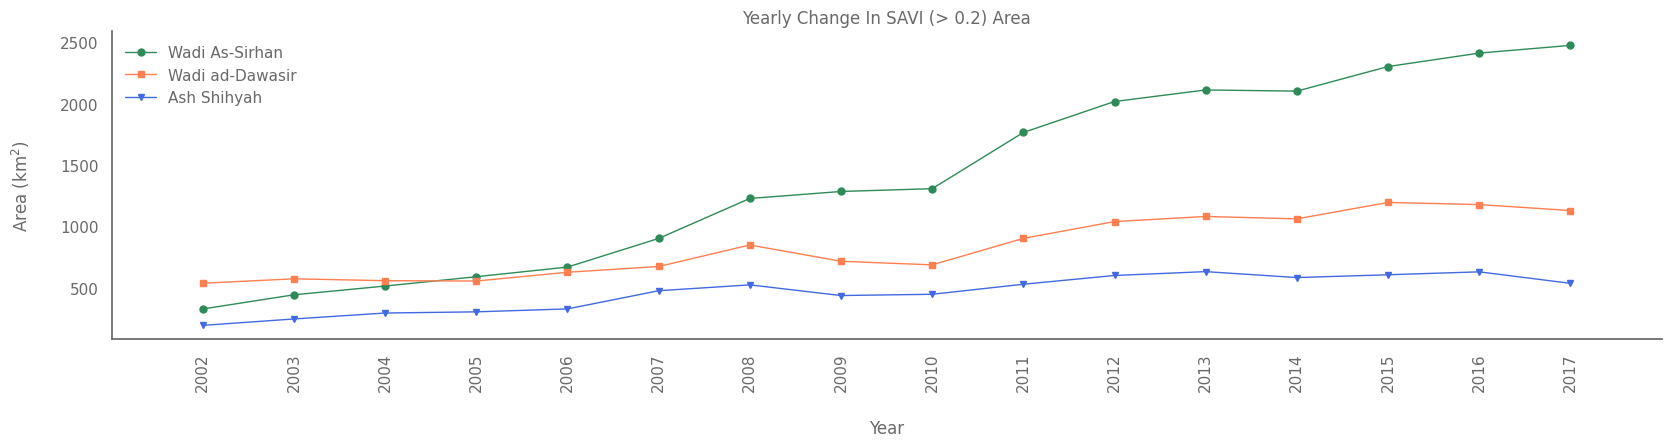

In [ ]:
sns.set(rc={
            'axes.axisbelow': False,
            'axes.edgecolor': 'dimgray',
            'axes.facecolor': 'None',
            'axes.grid': False,
            'axes.labelcolor': 'dimgray',
            'axes.spines.right': False,
            'axes.spines.top': False,
            'figure.facecolor': 'white',
            'lines.solid_capstyle': 'round',
            'patch.edgecolor': 'w',
            'patch.force_edgecolor': True,
            'text.color': 'dimgray',
            'xtick.bottom': False,
            'xtick.color': 'dimgray',
            'xtick.direction': 'out',
            'xtick.top': False,
            'ytick.color': 'dimgray',
            'ytick.direction': 'out',
            'ytick.left': False,
            'ytick.right': False})
sns.set_context("notebook", rc={"font.size":10,
                                "axes.titlesize":12,
                                "axes.labelsize":12})

plt.figure(figsize=(20, 4))

for regionData, params in zip(saviAreaPerYear, regionLineParams):
    years = list(regionData.keys())
    counts = list(regionData.values())
    line, = plt.plot(years,
                     counts,
                     linewidth=1,
                     color=params[0],
                     marker=params[1],
                     markersize=params[2],
                     label=params[3])

plt.xlim(2001, 2018)
plt.ylabel('Area (km$^2$)', labelpad=20)
plt.xlabel('Year', labelpad=20)
plt.title('Yearly Change In SAVI (> 0.2) Area')
plt.xticks(years, rotation=90)
#plt.xticks(years[::2], rotation=90)
plt.legend(loc='upper left', frameon=False)

plt.show()

#GRACE Graph

In [ ]:
#Get GRACE data
collection = ee.ImageCollection('NASA/GRACE/MASS_GRIDS/LAND')
start_date = '2002-01-01'
end_date = '2020-12-31'

graceCollectionList = []
for region in regions:
  # Filter the collection by date and region
  graceCollectionList.append(collection.filterDate(start_date, end_date)
                                       .filterBounds(region))

In [ ]:
graceMeanPerYear = []
for collection, region in zip(graceCollectionList, regions):
  #Add GRACE mean and year data to collections
  mean = collection.map(lambda image: getMeanOverTime(image, region))

  #Extract GRACE mean and year data
  yearsList = mean.aggregate_array('year').getInfo()
  meanDictList = mean.aggregate_array('mean').getInfo()

  meanList = []
  for mean in meanDictList:
    #Select mean intrument
    meanList.append(mean['lwe_thickness_csr'])

  #Iterate over the dates and means and average by date
  yearlyAverages = {}
  for year, mean in zip(yearsList, meanList):
      if year not in yearlyAverages:
          yearlyAverages[year] = []
      yearlyAverages[year].append(mean)

  #Append dict with years as keys and means as values
  graceMeanPerYear.append({year: sum(means) / len(means) for year, means in yearlyAverages.items()})

KeyboardInterrupt: ignored

In [ ]:
#Set plot parameters
fig, ax = plt.subplots(figsize=(20, 4))

for regionData, params in zip(graceMeanPerYear, regionLineParams):
    years = list(regionData.keys())
    counts = list(regionData.values())
    line, = plt.plot(years,
                     counts,
                     linewidth=1,
                     color=params[0],
                     marker=params[1],
                     markersize=params[2],
                     label=params[3])


plt.legend(loc='lower left', frameon=False)
plt.xlabel('Year', labelpad=20)
plt.ylabel('Vertical Land Water Thickness (cm)', labelpad=20)
plt.title('Yearly Change in Average Vertical Land Water Thickness')
plt.xticks(years)
plt.xticks(rotation=90)
ax.yaxis.set_major_locator(MultipleLocator(5))

#Show plot
plt.show()

# Timelapse Visualizations

In [ ]:
#Timelapse parameters
fullStartDate = f'{startYear}-{startDate}'
fullEndDate = f'{endYear}-{endDate}'
saviParams = {'min': -0.5, 'max': .75}
paletteParams = ['coral', 'white', 'seagreen']

#Create timelapse
for region, saviData in zip(regions, saviCollectionList):
  geemap.create_timelapse(saviData,
                          fullStartDate,
                          fullEndDate,
                          region=region,
                          bands='SAVI',
                          frequency='year',
                          reducer='min',
                          date_format='YYYY',
                          out_gif=None,
                          palette=paletteParams,
                          vis_params=saviParams,
                          dimensions=1000,
                          frames_per_second=1,
                          crs='EPSG:3857',
                          overlay_data=None,
                          overlay_color='black',
                          overlay_width=1,
                          overlay_opacity=1.0,
                          title=None,
                          title_xy=('2%', '95%'),
                          add_text=True,
                          text_xy=('2%', '2%'),
                          text_sequence=None,
                          font_type='arial.ttf',
                          font_size=30,
                          font_color='black',
                          add_progress_bar=None,
                          progress_bar_color='black',
                          progress_bar_height=5,
                          add_colorbar=None,
                          colorbar_width=6.0,
                          colorbar_height=0.8,
                          colorbar_label=None,
                          colorbar_label_size=12,
                          colorbar_label_weight='normal',
                          colorbar_tick_size=10,
                          colorbar_bg_color=None,
                          colorbar_orientation='horizontal',
                          colorbar_dpi='figure',
                          colorbar_xy=None,
                          colorbar_size=(300, 300),
                          loop=0,
                          mp4=True,
                          fading=False)

Total number of images: 16

Total number of images: 16

Total number of images: 16



#Regression

In [ ]:
for saviData, graceData in zip(saviAreaPerYear, graceMeanPerYear):
  #Define the change in area over time and change in mass over time as arrays

  change_area = list(saviData.values())
  change_mass = list(graceData.values())

  #Add a constant term to the independent variable (change in area)
  X = sm.add_constant(change_area)

  #Fit the linear regression model
  model = sm.OLS(change_mass, X)
  results = model.fit()

  #Print the regression results
  print(results.summary())

In [ ]:
# Create scatter plot
fig, ax = plt.subplots(figsize=(15, 4))
plt.scatter(change_area, change_mass)

# Customize the plot
plt.xlabel('X-axis label')
plt.ylabel('Y-axis label')
plt.title('Scatter Plot')

# Display the plot
plt.show()

In [ ]:
# Calculate Pearson correlation coefficient
correlation_coefficient = np.corrcoef(change_area, change_mass)[0, 1]
print(f"Pearson's correlation coefficient: {correlation_coefficient}")